In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import calendar
import itertools
import shap

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Helpers

In [96]:
def output_to_accu(model, X, y):
    nb_errors = 0
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        _, predicted_classes = output.max(1)
        for k in range(1):
            if y[b + k, predicted_classes[k]] != 1.:
                nb_errors = nb_errors + 1
    accuracy = 100 * (1 - nb_errors / X.size(0))
    return accuracy

In [97]:
def output_to_loss(model, X, y):
    nb_errors = 0
    loss = 0
    criterion = nn.BCELoss()
    for b in range(0, X.size(0)):
        output = model(X.narrow(0, b, 1))
        loss += criterion(output, y.narrow(0, b, 1))
        
    return loss

In [98]:
def perf_to_stat(perf_gross, perf_net):
    
    #perf_gross = pred_to_perf(df_pred, 0.)
    #perf_net = pred_to_perf(df_pred, 0.0012)
    
    year_group_gross = perf_gross.resample('Y')
    year_group_net = perf_net.resample('Y')

    average_year_return_gross = ((year_group_gross.last() - year_group_gross.first()) / year_group_gross.first()).mean() * 100
    average_year_return_net = ((year_group_net.last() - year_group_net.first()) / year_group_net.first()).mean() * 100

    average_year_std = perf_gross.pct_change().std() * np.sqrt(256) * 100
    average_year_sharpe = average_year_return_net / average_year_std
    
    dd_window = 252
    roll_max = perf_gross.rolling(dd_window).max()
    daily_dd = perf_gross / roll_max - 1
    max_daily_dd = np.abs(daily_dd.rolling(dd_window, min_periods=1).min()).max() * 100

    return [average_year_return_gross, average_year_return_net, average_year_std, average_year_sharpe, max_daily_dd]

In [122]:
def performance_plot(df_pred, model):
    perf_pred_gross = pred_to_perf(df_pred, 0.).rename('Model without transaction costs')
    perf_pred_net = pred_to_perf(df_pred, 0.0012).rename('Model with transaction costs')

    data = pd.concat([perf_pred_gross, perf_pred_net, price_to_perf(bench_price[df_pred.index[0]:df_pred.index[-1]])], axis=1)

    fig = plt.figure(figsize=(14,6))
    plt.title(model, fontsize=14)
    sns.lineplot(data=data.rolling(20).mean(), dashes=False)
    plt.show()

In [100]:
def turnover(df_pred):
    return (df_pred.diff().fillna(0) != 0).any(axis=1).astype(int).sum()

In [101]:
def annual_alpha_plot_grossnet(perf_bench, df_pred, model):
    perf_pred_gross = pred_to_perf(df_pred, 0.).rename('Model without transaction costs')
    perf_pred_net = pred_to_perf(df_pred, 0.0012).rename('Model with transaction costs')

    year_group_bench = perf_bench.resample('Y')
    year_group_pred_gross = perf_pred_gross.resample('Y')
    year_group_pred_net = perf_pred_net.resample('Y')

    annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
    annual_returns_pred_gross = (year_group_pred_gross.last() - year_group_pred_gross.first()) / year_group_pred_gross.first()
    annual_returns_pred_net = (year_group_pred_net.last() - year_group_pred_net.first()) / year_group_pred_net.first()


    annual_diff_gross = (annual_returns_pred_gross - annual_returns_bench) * 100
    annual_diff_net = (annual_returns_pred_net - annual_returns_bench) * 100

    df_annual_diff = pd.DataFrame(columns=['year', 'gross', 'net'])
    df_annual_diff['year'] = annual_diff_net.index.year
    df_annual_diff['year'] = df_annual_diff.year.apply(str)
    df_annual_diff['gross'] = annual_diff_gross.values
    df_annual_diff['net'] = annual_diff_net.values
    df_annual_diff = df_annual_diff.melt(id_vars=['year'], var_name='gross_net', value_name='alpha')
    df_annual_diff['sign'] = np.sign(df_annual_diff.alpha)

    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(data=df_annual_diff, x='year', y='alpha', hue='gross_net', dodge=True)
    #ax.get_legend().remove()
    ax.get_legend().set_title(None)
    plt.ylabel('Alpha (%)')
    plt.xlabel('Year')
    plt.title('Annual Return of the model over Benchmark Return : ' + model)
    plt.show()

In [102]:
def annual_alpha_plot(perf_bench, df_pred, model):
    
    perf_pred_gross = pred_to_perf(df_pred, 0.).rename('Model without transaction costs')
    perf_pred_net = pred_to_perf(df_pred, 0.0012).rename('Model with transaction costs')
    
    year_group_bench = perf_bench.resample('Y')
    year_group_pred_gross = perf_pred_gross.resample('Y')
    year_group_pred_net = perf_pred_net.resample('Y')
    
    annual_returns_bench = (year_group_bench.last() - year_group_bench.first()) / year_group_bench.first()
    annual_returns_pred_gross = (year_group_pred_gross.last() - year_group_pred_gross.first()) / year_group_pred_gross.first()
    annual_returns_pred_net = (year_group_pred_net.last() - year_group_pred_net.first()) / year_group_pred_net.first()


    annual_diff_gross = (annual_returns_pred_gross - annual_returns_bench) * 100
    annual_diff_net = (annual_returns_pred_net - annual_returns_bench) * 100
    
    df_annual_diff = pd.DataFrame(columns=['year', 'alpha_gross', 'alpha_net'])
    df_annual_diff['year'] = annual_diff_gross.index.year
    df_annual_diff['year'] = df_annual_diff.year.apply(str)
    df_annual_diff['alpha_gross'] = annual_diff_gross.values
    df_annual_diff['alpha_net'] = annual_diff_gross.values
    df_annual_diff['sign_gross'] = np.sign(df_annual_diff.alpha_gross)
    df_annual_diff['sign_net'] = np.sign(df_annual_diff.alpha_gross)

    fig, ax = plt.subplots(figsize=(14,6))
    sns.barplot(data=df_annual_diff, x='year', y='alpha_gross', hue='sign_gross', dodge=False)
    ax.get_legend().remove()
    plt.ylabel('Alpha (%)')
    plt.xlabel('Year')
    plt.title('Annual Return of the model (gross) over Benchmark Return : ' + model)
    plt.show()

In [103]:
def correlation(df_pred1, df_pred2):
    nb_match = 0
    L = len(df_pred1)
    for k in range(L):
        idx = np.where(df_pred1.iloc[k].values == 1)
        if df_pred2.iloc[k].values[idx] == 1.:
            nb_match += 1
    correlation = nb_match / L
    return correlation

In [104]:
def pred_to_perf(df_pred, tax=0., log=False):
    first_date = df_pred.index[0]
    last_date = df_pred.index[-1]
    daily_ret = daily_returns[first_date:last_date]
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
    df_perf = (df_pred_daily * daily_ret).sum(axis=1)
    df_cost = (df_pred_daily.diff().fillna(0) != 0).any(axis=1).astype(int) * tax
    if log is False:
        perf = (1 + df_perf - df_cost).cumprod()
    else:
        perf = np.log(1 + df_perf - df_cost).cumsum()
    return perf

In [105]:
def pred_to_daily_ret(df_pred, tax=0., log=False):
    first_date = df_pred.index[0]
    last_date = df_pred.index[-1]
    daily_ret = daily_returns[first_date:last_date]
    df_pred_daily = df_pred.reindex(daily_ret.index, method='ffill').shift(1)
    df_daily_ret = (df_pred_daily * daily_ret).sum(axis=1)
    return df_daily_ret

In [106]:
def price_to_perf(df, log=False):
    if log is False:
        perf = (1 + df.pct_change().fillna(0)).cumprod()
    else:
        perf = np.log(1 + df.pct_change().fillna(0)).cumsum()
    return perf

# DATA

In [124]:
indices_price_excel = pd.read_csv('SW_data/prices.csv', index_col=0, parse_dates=True)
#indices_price_excel = pd.read_excel('SW_data/indices_price.xlsx', parse_dates=True, index_col=0, skiprows=[0,1,2,3,5,6,7])
#indices_price_excel.to_csv('SW_data/prices.csv', index=True)
indices_price_excel.head()

,SPI Index,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1996-01-04,2182.67,426.47,2049.35,423.28,3395.8
1996-01-05,2175.09,426.04,2054.88,424.38,3376.1
1996-01-08,2176.68,427.94,2071.98,427.67,3368.1
1996-01-09,2174.13,428.33,2077.84,429.26,3361.5
1996-01-10,2149.15,425.25,2068.74,426.99,3314.8


In [25]:
bench_price = indices_price_excel['SPI Index']
price = indices_price_excel[indices_price_excel.columns[1:]]
daily_returns = price.pct_change().dropna()
daily_return_bench = bench_price.pct_change()
price.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1996-01-04,426.47,2049.35,423.28,3395.8
1996-01-05,426.04,2054.88,424.38,3376.1
1996-01-08,427.94,2071.98,427.67,3368.1
1996-01-09,428.33,2077.84,429.26,3361.5
1996-01-10,425.25,2068.74,426.99,3314.8


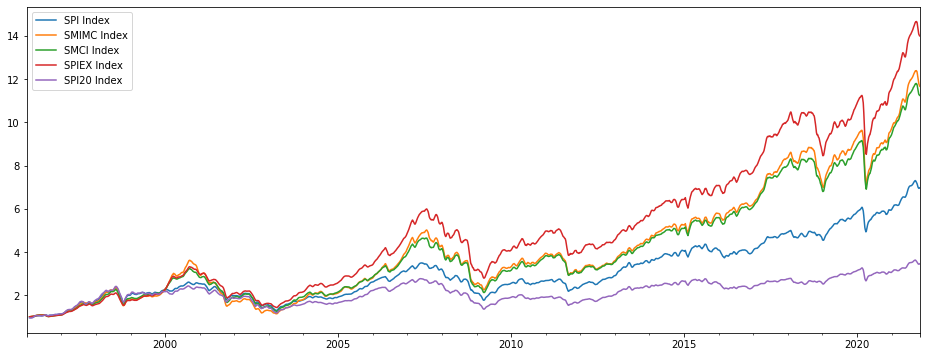

In [26]:
fig, ax = plt.subplots(figsize=(16,6))
(indices_price_excel.pct_change() + 1).cumprod().rolling(20).mean().plot(ax=ax)
plt.show()

In [34]:
mom12 = price.pct_change(periods=21 * 12)
mom6 = price.pct_change(periods=21 * 6)
mom1 = price.pct_change(periods=21 * 1)

ma200 = np.log(price / price.rolling(window=200).mean())
ma100 = np.log(price / price.rolling(window=100).mean())
ma50 = np.log(price / price.rolling(window=50).mean())

vol12 = price.rolling(window=21 * 12).std()
vol6 = price.rolling(window=21 * 6).std()
vol1 = price.rolling(window=21 * 1).std()

In [35]:
ema_12 = price.ewm(span=10).mean()
ema_26 = price.ewm(span=60).mean()
MACD = ema_12 - ema_26

In [36]:
def RSI(price, window):
    price_diff = price.diff()
    gain = price_diff.mask(price_diff < 0, 0.0)
    loss = - price_diff.mask(price_diff > 0, -0.0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 1 - 1 / (1 + rs)
    return rsi

In [37]:
RSI14 = RSI(price, 14)
RSI9 = RSI(price, 9)
RSI3 = RSI(price, 3)

In [38]:
df_dict = {}
df_X = pd.DataFrame()
for col in price.columns:
    df_temp = pd.concat([ma50[col], ma100[col], ma200[col],
                         mom12[col], mom6[col], mom1[col],
                         vol12[col], vol6[col], vol1[col],
                         RSI14[col], RSI9[col], RSI3[col], 
                         MACD[col]], axis=1).loc['1997-01-01':].fillna(method='ffill')
    df_temp.columns = ['ma50', 'ma100', 'ma200', 'mom12', 'mom6', 'mom1', 
                       'vol12', 'vol6', 'vol1', 'RSI14', 'RSI9', 'RSI3', 'MACD']
    df_dict[col] = df_temp
    
df_X = pd.concat(df_dict, axis=1)

In [39]:
df_X.head(10)

SMIMC Index                                                    \
                  ma50     ma100     ma200     mom12      mom6      mom1   
1997-01-01    0.021183  0.041832  0.037418  0.122313  0.031053  0.009178   
1997-01-02    0.020247  0.040893  0.037217  0.117781  0.031187  0.010355   
1997-01-03    0.030225  0.050985  0.048054  0.129028  0.042958  0.019935   
1997-01-06    0.035061  0.055928  0.053765  0.131691  0.056981  0.045572   
1997-01-07    0.042809  0.063860  0.062583  0.133435  0.070223  0.046394   
1997-01-08    0.054352  0.075665  0.075374  0.152582  0.103478  0.053748   
1997-01-09    0.056038  0.077784  0.078475  0.166060  0.116594  0.064430   
1997-01-10    0.053180  0.075289  0.076928  0.161219  0.116676  0.049433   
1997-01-13    0.065188  0.087865  0.090478  0.175322  0.132048  0.071509   
1997-01-14    0.061548  0.084724  0.088196  0.177523  0.144266  0.059179   

                                                       ... SPI20 Index  \
                vol12       vol6       vol1     RSI14  ...       mom12   
1997-01-01  15.053968  13.730276   3.227452  0.585078  ...    0.219023   
1997-01-02  15.005942  13.862270   3.385890  0.707792  ...    0.211196   
1997-01-03  14.992277  14.069762   4.003735  0.720844  ...    0.223900   
1997-01-06  15.008205  14.332086   4.299966  0.781789  ...    0.204432   
1997-01-07  15.079490  14.669200   5.272626  0.827436  ...    0.205896   
1997-01-08  15.198429  15.118869   6.902211  0.952399  ...    0.213853   
1997-01-09  15.304328  15.568567   8.074479  0.954594  ...    0.232122   
1997-01-10  15.407685  15.979529   9.071763  0.973387  ...    0.225406   
1997-01-13  15.588925  16.521204  10.421413  0.982497  ...    0.238011   
1997-01-14  15.739782  16.975392  11.472019  0.956546  ...    0.248230   

                                                                             \
                mom6      mom1       vol12        vol6       vol1     RSI14   
1997-01-01  0.044734  0.004510  184.851943  110.078930  33.052024  0.692056   
1997-01-02  0.040707  0.008081  184.295583  111.326139  34.950821  0.766167   
1997-01-03  0.034147  0.006720  183.372518  112.449337  36.425919  0.714199   
1997-01-06  0.036452  0.023022  182.636808  113.421332  35.193602  0.725153   
1997-01-07  0.044602  0.012623  181.813920  114.392678  35.576269  0.674269   
1997-01-08  0.072537  0.015314  181.058488  115.380969  37.183745  0.706109   
1997-01-09  0.084787  0.028152  180.116202  116.463640  38.953134  0.727164   
1997-01-10  0.081717  0.022642  179.015314  117.184352  38.901280  0.709377   
1997-01-13  0.085757  0.035475  177.952579  118.316387  38.534428  0.772282   
1997-01-14  0.117075  0.029567  176.684714  118.500060  40.126586  0.781405   

                                           
                RSI9      RSI3       MACD  
1997-01-01  0.768827  0.810559  66.997240  
1997-01-02  0.748332  0.000000  69.689354  
1997-01-03  0.849567  0.000000  71.091320  
1997-01-06  0.762136  0.000000  69.347797  
1997-01-07  0.755534  0.000000  67.420480  
1997-01-08  0.798253  0.561224  68.771917  
1997-01-09  0.732068  0.979638  72.605636  
1997-01-10  0.494857  0.697262  72.404889  
1997-01-13  0.652055  0.724340  76.002015  
1997-01-14  0.676020  0.658182  79.602618  

[10 rows x 52 columns]

In [64]:
monthly_return = price.pct_change().shift(1).resample('M').agg(lambda x: (x + 1).prod() - 1)
best_pred = monthly_return.rank(axis=1).replace({1: 0., 2: 0., 3: 1., 4: 1.}).shift(-1).loc['1997-01-31':]
best_pred_one = monthly_return.rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 1.}).shift(-1).loc['1997-01-31':]
best_pred_one.head()

,SMIMC Index,SMCI Index,SPIEX Index,SPI20 Index
1997-01-31,0.0,0.0,0.0,1.0
1997-02-28,0.0,0.0,1.0,0.0
1997-03-31,0.0,0.0,0.0,1.0
1997-04-30,1.0,0.0,0.0,0.0
1997-05-31,0.0,0.0,0.0,1.0


In [65]:
class MLP(nn.Module):
    def __init__(self, x1, x2, x3, pdrop=0.2):
        super().__init__()
        self.fc1 = nn.Linear(x1 * x2 * x3, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 4)
        self.drop = nn.Dropout(pdrop)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.relu(self.drop(self.fc1(x)))
        x = self.relu(self.drop(self.fc2(x)))
        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

In [66]:
class ConvNet(nn.Module):
    def __init__(self, dim1, dim2, dim3, dim1_kernel1=2, dim2_kernel1=2, dim1_kernel2=2, dim2_kernel2=2, pdrop=0.01):
        super().__init__()
        
        self.dim1 = dim1
        self.dim2 = dim2
        self.dim3 = dim3
        
        self.conv1 = nn.Conv3d(1, 8, kernel_size=(dim1_kernel1, dim2_kernel1, dim3))
        self.conv2 = nn.Conv3d(8, 16, kernel_size=(dim1_kernel2, dim2_kernel2, 1))
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(16 * (dim1 - dim1_kernel1 - dim1_kernel2 + 2) * (dim2 - dim2_kernel1 - dim2_kernel2 + 2), 32)
        self.fc2 = nn.Linear(32, 4)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.drop = nn.Dropout(pdrop)
        self.drop2d = nn.Dropout2d(pdrop)

    def forward(self, x):
        
        x = x.view(x.size(0), 1, x.size(1), x.size(2), x.size(3))
    
        x = self.relu(self.drop2d(self.conv1(x)))
        x = self.relu(self.drop2d(self.conv2(x)))
        
        #print(x.shape)
        x = x.flatten(start_dim=1)

        x = self.relu(self.drop(self.fc1(x)))
        # x = self.relu(self.drop(self.fc2(x)))
        x = self.sigmoid(self.fc2(x))

        return x

In [67]:
class LSTM(nn.Module):

    def __init__(self, input_size, output_size, hidden_size=5, num_layers=2, dropout=0):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=self.dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size)
        x = x.view(x.size(0), x.size(1), x.size(2) * x.size(3))
        x, _ = self.lstm(x, (h0, c0))
        x = self.relu(x)
        x = self.sigmoid(self.fc(x[:, -1, :]))
        
        return x

In [71]:
def strategie(df_input_all, best_pred, model_name='MLP', nb_epochs=50, input_period=8, month_test_period=5, training_window=5, mini_batch_size=1, verbose=0):
    
    first_end_date = '2002-02-01'
    num_tickers = 4
    num_features = 13
    
    # ML parameters
    pdrop=0.25
    eta = 1e-3
    
    # LSTM parameters
    hidden_size = 20
    num_layers = 10
    
    prob_output = []
    pred_output = []
    all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
    for i, end_date in enumerate(tqdm(all_end_dates)):
        # Data
        start_date = end_date - relativedelta(years=training_window)
        #start_date_input = start_date.replace(day=1) 
        start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
        df_input = df_input_all.loc[start_date_input:end_date]
        df_output = best_pred.loc[start_date:end_date] # best_pred // best_pred_one

        X = []
        for idx in df_output.index:
            df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
            X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
            X.append(X_period)
        X = np.array(X)
        y = df_output.values

        if i == 0:
            #first_start_date_test = end_date.replace(day=31, month=1)
            first_start_date_test = end_date - relativedelta(months=5)

        # start_date_test = end_date.replace(day=31, month=1)
        start_date_test = (end_date - relativedelta(months=month_test_period))
        year_test, month_test = start_date_test.year, start_date_test.month
        start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
        split_index = df_output.index.get_loc(start_date_test)    
        X_train, y_train = X[:split_index], y[:split_index]
        X_test, y_test = X[split_index:], y[split_index:]

        X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

        train_mean = X_train.mean(dim=[0,1,2], keepdim=True)
        train_std = X_train.std(dim=[0,1,2], keepdim=True)
        X_train = X_train.sub_(train_mean).div_(train_std)

        #train_size = X_train.size(0)
        #shuffle_idx = torch.randperm(train_size)
        #X_train = X_train[shuffle_idx, :, :]
        #y_train = y_train[shuffle_idx, :]

        test_mean = X_test.mean(dim=[0,1,2], keepdim=True)
        test_std = X_test.std(dim=[0,1,2], keepdim=True)
        X_test = X_test.sub_(test_mean).div_(test_std)

        # Model
        dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
        if model_name == 'MLP':
            model = MLP(dim1, dim2, dim3, pdrop=pdrop)
        elif model_name == 'ConvNet':
            model = ConvNet(dim1, dim2, dim3, pdrop=pdrop)
        elif model_name == 'LSTM':
            model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, hidden_size=hidden_size, num_layers=num_layers)
            
        optimizer = torch.optim.Adam(model.parameters(), lr=eta)
        #optimizer = torch.optim.RMSprop(model.parameters(), lr=eta)
        criterion = nn.BCELoss()
        #criterion = nn.MSELoss()

        train_accu_list = []
        train_loss_list = []
        test_accu_list = []
        test_loss_list = []
        for e in range(nb_epochs):
            acc_loss = 0
            model.train()
            for b in range(0, X_train.size(0), mini_batch_size):
                optimizer.zero_grad()
                output = model(X_train.narrow(0, b, mini_batch_size))
                loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
                acc_loss = acc_loss + loss.item()
                loss.backward()
                optimizer.step()
            
            model.eval()
            train_accu = output_to_accu(model, X_train, y_train)
            train_accu_list.append(train_accu)
            test_accu = output_to_accu(model, X_test, y_test)
            test_accu_list.append(test_accu)

            train_loss = output_to_loss(model, X_train, y_train).detach().numpy()
            train_loss_list.append(train_loss)
            test_loss = output_to_loss(model, X_test, y_test).detach().numpy()
            test_loss_list.append(test_loss)

            if verbose == 1:
                if (e % 5) == 0:
                    print('epoch', e + 1, ':', acc_loss)
        
        if verbose == 1:
            fig = plt.figure(figsize=(12,6))
            plt.plot(list(range(nb_epochs)), train_loss_list, label='Train loss')
            plt.plot(list(range(nb_epochs)), test_loss_list, label='Test loss')
            plt.legend()
            plt.show()
            fig = plt.figure(figsize=(12,6))
            plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
            plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
            plt.legend()
            plt.show()
        #if verbose == 2:
            # e = shap.explainers.Exact(model(X_train), X_train)
            # shap_values = e(X_train)
            #e = shap.DeepExplainer(model, X_train.narrow(0, b, 1))
            #shap_values = e.shap_values(X_test.narrow(0, b, 1))
            #shap.plots.bar(shap_values)


        model.eval()
        pred = np.zeros((X_test.size(0), y_test.size(1)))
        output_list = []
        for b in range(0, X_test.size(0)):
            output = model(X_test.narrow(0, b, 1))
            _, pred_index = output.max(1)
            pred[b, pred_index.item()] = 1
            output_list.append(output.detach().numpy())
        prob_output.append(np.array(output_list))
        pred_output.append(pred)

    pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
    prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
    df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)
    return df_pred, df_prob

In [146]:
models_list = ['MLP', 'ConvNet', 'LSTM']
#models_list = ['LSTM']
df_pred_dict = {}
df_prob_dict = {}
perf_pred_dict_gross = {}
perf_pred_dict_net = {}
nb_epochs = 5
input_period = 8
mini_batch_size = 5
verbose = 0
training_window = 5

for i, model_name in enumerate(models_list):
    df_pred_dict[model_name], df_prob_dict[model_name] = strategie(df_input_all=df_X, best_pred=best_pred_one, model_name=model_name, nb_epochs=nb_epochs, input_period=input_period, mini_batch_size=mini_batch_size, verbose=verbose, training_window=training_window)
    perf_pred_dict_gross[model_name] = pred_to_perf(df_pred_dict[model_name])
    perf_pred_dict_net[model_name] = pred_to_perf(df_pred_dict[model_name], 0.0012)
    if i == 0:
        df_prob_ensemble = df_prob_dict[model_name].copy()
    else:
        df_prob_ensemble += df_prob_dict[model_name]

df_prob_ensemble /= 3
df_pred_dict['Ensemble'] = df_prob_ensemble.rank(axis=1).replace({1: 0., 2: 0., 3: 0., 4: 1.})


100%|██████████| 40/40 [02:02<00:00,  3.07s/it]


In [147]:
perf_bench = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=False)
perf_bench_log = price_to_perf(bench_price.loc[df_pred_dict[model_name].index[0]:df_pred_dict[model_name].index[-1]], log=True)

In [148]:
bench_stats = perf_to_stat(perf_bench, perf_bench)
stats = []
stats.append(bench_stats + [0])
for model_name in df_pred_dict.keys():
    
    perf_gross = pred_to_perf(df_pred_dict[model_name], 0., log=False)
    perf_net = pred_to_perf(df_pred_dict[model_name], 0.0012, log=False)
    
    turnover_num = turnover(df_pred_dict[model_name])
    stats.append(perf_to_stat(perf_gross, perf_net) + [turnover(df_pred_dict[model_name])])
stats = np.array(stats)

df_stats = pd.DataFrame(data=stats, columns=['Gross avg. annual return (%)','Net avg. annual return (%)', 'Avg. annual vol. (%)', 'Avg Sharpe ratio', 'Max. Drawdown (%)', 'Turnover'], index=['Benchmark SPI'] + list(df_pred_dict.keys())).round(2)
df_stats.Turnover = df_stats.Turnover.apply(int)
df_stats

,Gross avg. annual return (%),Net avg. annual return (%),Avg. annual vol. (%),Avg Sharpe ratio,Max. Drawdown (%),Turnover
Benchmark SPI,8.18,8.18,17.12,0.48,44.52,0
MLP,10.34,9.87,16.34,0.60,47.85,85
ConvNet,9.64,9.54,18.05,0.53,47.14,15
LSTM,10.56,10.36,16.20,0.64,47.12,33
Ensemble,10.63,10.41,17.40,0.60,47.14,35


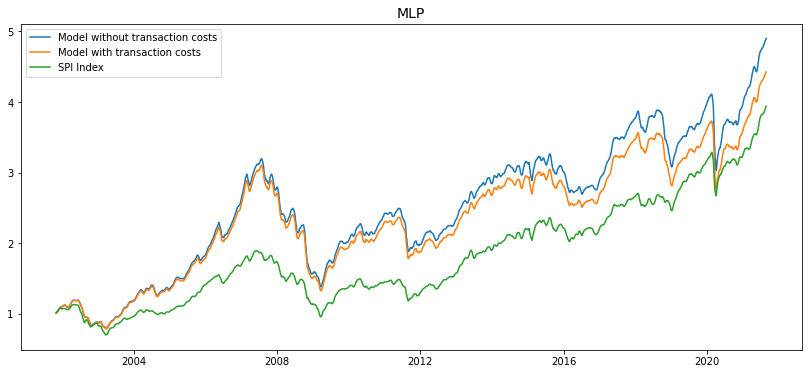

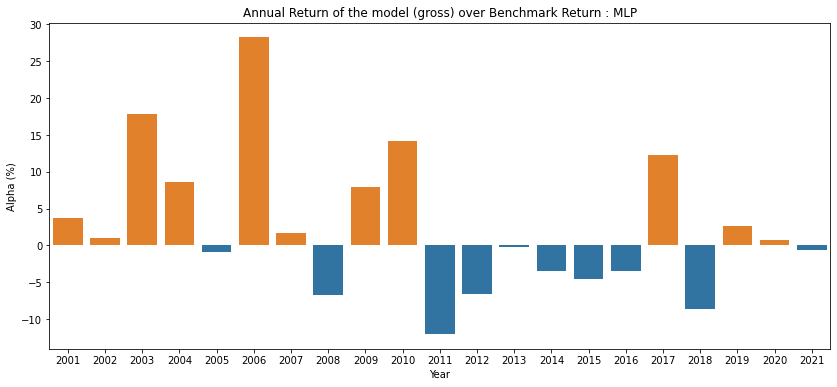

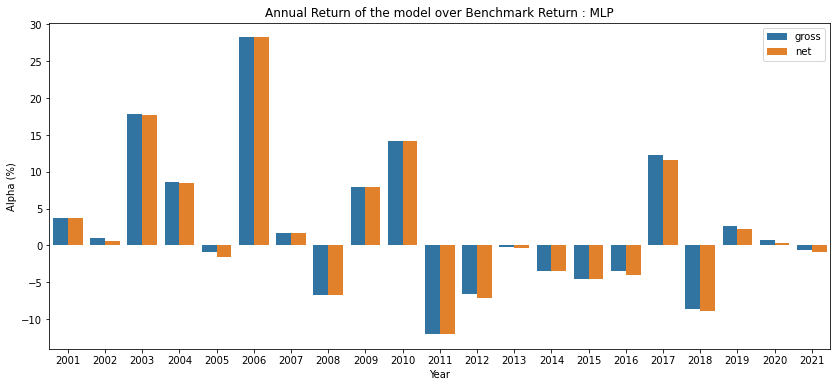

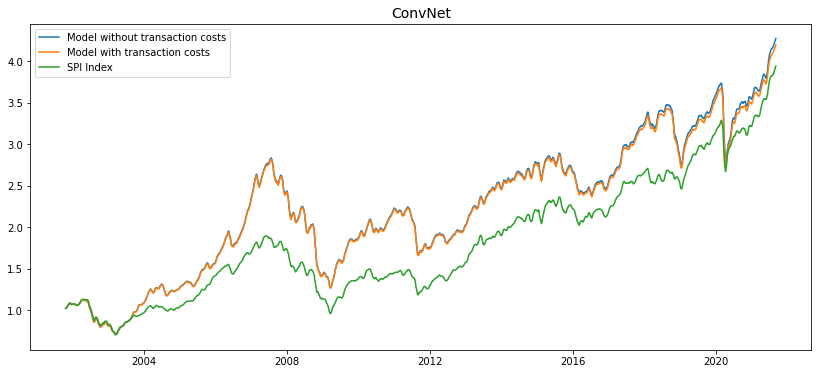

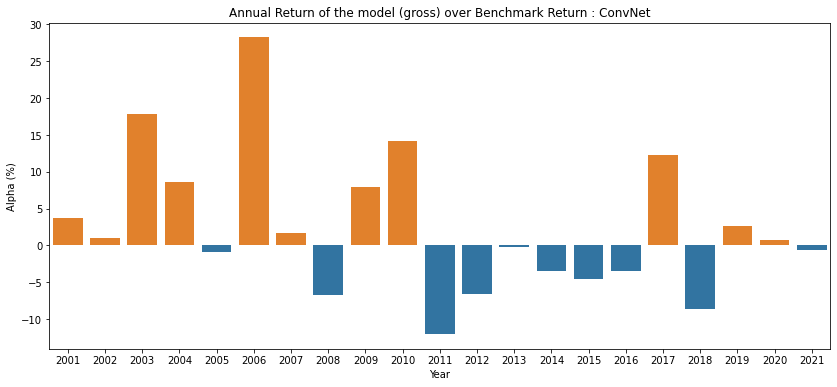

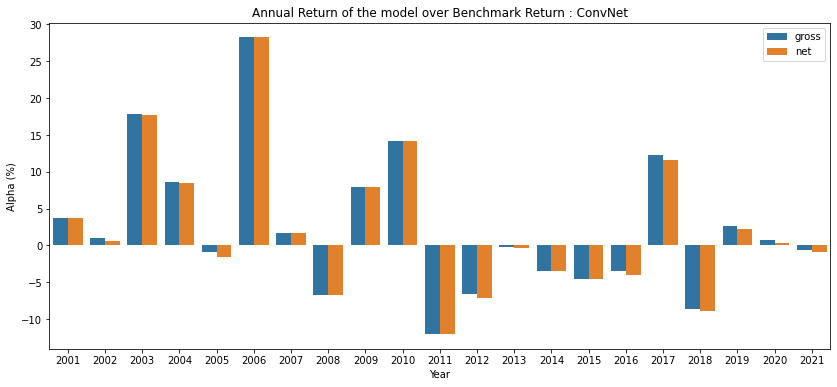

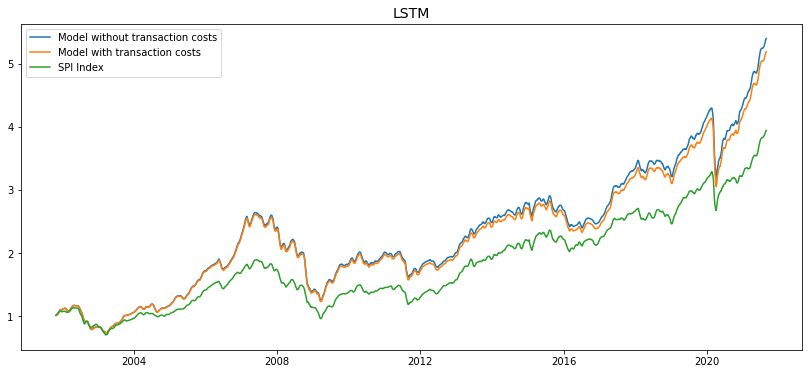

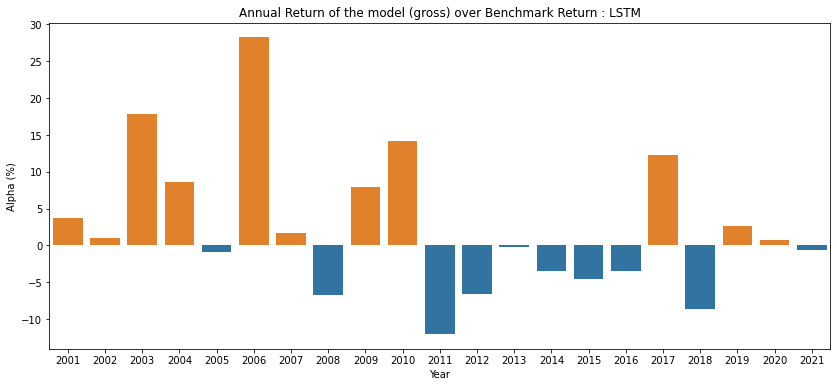

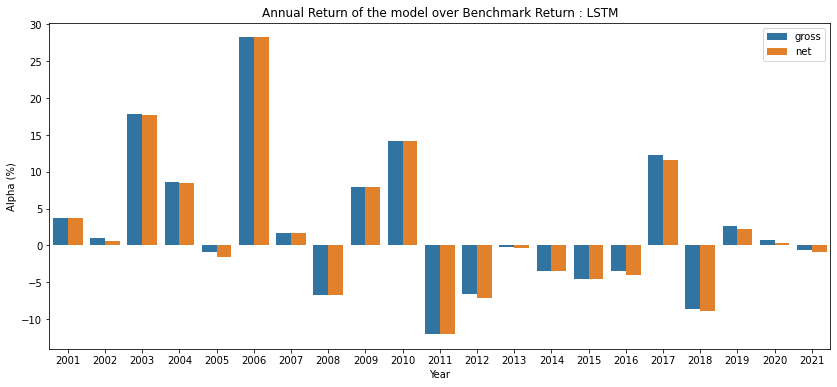

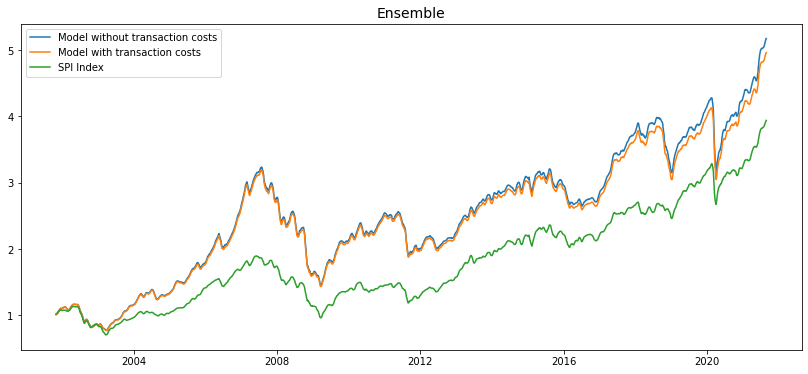

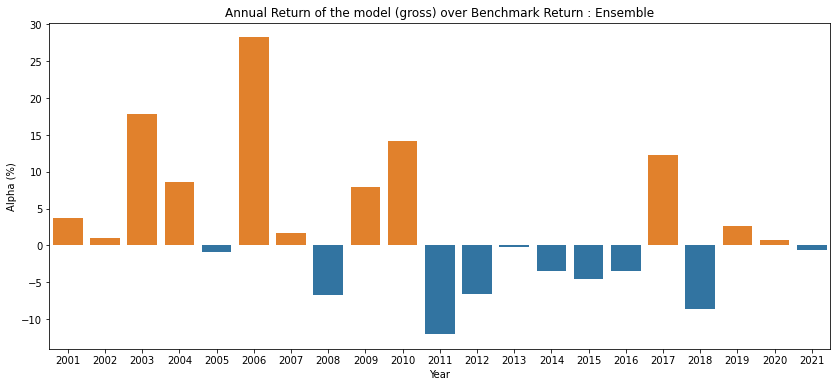

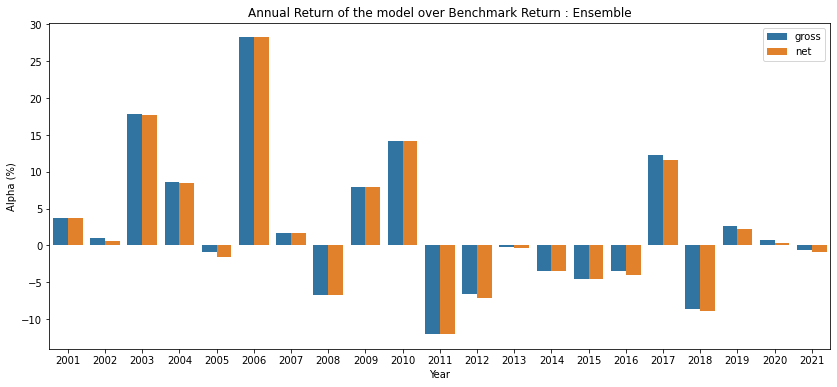

In [153]:
for model_name in df_pred_dict.keys():
    performance_plot(df_pred_dict[model_name], model_name)
    annual_alpha_plot(perf_bench, df_pred_dict[model], model_name)
    annual_alpha_plot_grossnet(perf_bench, df_pred_dict[model], model_name)

In [154]:
df = pd.DataFrame(index=models_list, columns=models_list)
for comb in itertools.product(models_list, repeat=2):
    model1 = comb[0]
    model2 = comb[1]
    df.loc[model1][model2] = correlation(df_pred_dict[model1], df_pred_dict[model2])
df.round(0)

,MLP,ConvNet,LSTM
MLP,1.0,0.5375,0.404167
ConvNet,0.5375,1.0,0.520833
LSTM,0.404167,0.520833,1.0


In [41]:
first_end_date = '2002-02-01'
num_tickers = 4
num_features = 13
model_name = 'MLP'
df_input_all = df_X
month_test_period = 5
# ML parameters
pdrop=0.1
eta = 1e-3
nb_epochs = 1
input_period = 8
mini_batch_size = 1
verbose = 2
training_window = 5

# LSTM parameters
hidden_size = 20
num_layers = 5

prob_output = []
pred_output = []
all_end_dates = best_pred.loc[first_end_date:].asfreq('6M', method='ffill').index
for i, end_date in enumerate(tqdm(all_end_dates)):
    # Data
    start_date = end_date - relativedelta(years=training_window)
    #start_date_input = start_date.replace(day=1) 
    start_date_input = (start_date - relativedelta(weeks=input_period)).replace(day=1) 
    df_input = df_input_all.loc[start_date_input:end_date]
    df_output = best_pred.loc[start_date:end_date] # best_pred // best_pred_one

    X = []
    for idx in df_output.index:
        df_input_period = df_input.loc[:idx].asfreq('W', method='ffill').iloc[-input_period:]
        X_period = df_input_period.values.reshape(input_period, num_tickers, num_features)
        X.append(X_period)
    X = np.array(X)
    y = df_output.values

    if i == 0:
        #first_start_date_test = end_date.replace(day=31, month=1)
        first_start_date_test = end_date - relativedelta(months=5)

    # start_date_test = end_date.replace(day=31, month=1)
    start_date_test = (end_date - relativedelta(months=month_test_period))
    year_test, month_test = start_date_test.year, start_date_test.month
    start_date_test = start_date_test.replace(day=calendar.monthrange(year_test, month_test)[1])
    split_index = df_output.index.get_loc(start_date_test)    
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    X_train, y_train, X_test, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()

    train_mean = X_train.mean(dim=[0,1,2], keepdim=True)
    train_std = X_train.std(dim=[0,1,2], keepdim=True)
    X_train = X_train.sub_(train_mean).div_(train_std)

    #train_size = X_train.size(0)
    #shuffle_idx = torch.randperm(train_size)
    #X_train = X_train[shuffle_idx, :, :]
    #y_train = y_train[shuffle_idx, :]

    test_mean = X_test.mean(dim=[0,1,2], keepdim=True)
    test_std = X_test.std(dim=[0,1,2], keepdim=True)
    X_test = X_test.sub_(test_mean).div_(test_std)

    # Model
    dim1, dim2, dim3 = X_train.size(1), X_train.size(2), X_train.size(3)
    if model_name == 'MLP':
        model = MLP(dim1, dim2, dim3, pdrop=pdrop)
    elif model_name == 'ConvNet':
        model = ConvNet(dim1, dim2, dim3, pdrop=pdrop)
    elif model_name == 'LSTM':
        model = LSTM(input_size=num_tickers * num_features, output_size=num_tickers, hidden_size=hidden_size, num_layers=num_layers)

    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    #optimizer = torch.optim.RMSprop(model.parameters(), lr=eta)
    criterion = nn.BCELoss()
    #criterion = nn.MSELoss()

    train_accu_list = []
    train_loss_list = []
    test_accu_list = []
    test_loss_list = []
    for e in range(nb_epochs):
        acc_loss = 0
        model.train()
        for b in range(0, X_train.size(0), mini_batch_size):
            optimizer.zero_grad()
            output = model(X_train.narrow(0, b, mini_batch_size))
            loss = criterion(output, y_train.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()
            loss.backward()
            optimizer.step()

        model.eval()
        train_accu = output_to_accu(model, X_train, y_train)
        train_accu_list.append(train_accu)
        test_accu = output_to_accu(model, X_test, y_test)
        test_accu_list.append(test_accu)

        train_loss = output_to_loss(model, X_train, y_train).detach().numpy()
        train_loss_list.append(train_loss)
        test_loss = output_to_loss(model, X_test, y_test).detach().numpy()
        test_loss_list.append(test_loss)

        if verbose == 1:
            if (e % 5) == 0:
                print('epoch', e + 1, ':', acc_loss)

    if verbose == 1:
        fig = plt.figure(figsize=(12,6))
        plt.plot(list(range(nb_epochs)), train_loss_list, label='Train loss')
        plt.plot(list(range(nb_epochs)), test_loss_list, label='Test loss')
        plt.legend()
        plt.show()
        fig = plt.figure(figsize=(12,6))
        plt.plot(list(range(nb_epochs)), train_accu_list, label='Train accuracy')
        plt.plot(list(range(nb_epochs)), test_accu_list, label='Test accuracy')
        plt.legend()
        plt.show()
    #if verbose == 2:
        # e = shap.explainers.Exact(model(X_train), X_train)
        # shap_values = e(X_train)
        #e = shap.DeepExplainer(model, X_train.narrow(0, b, 1))
        #shap_values = e.shap_values(X_test.narrow(0, b, 1))
        #shap.plots.bar(shap_values)


    model.eval()
    pred = np.zeros((X_test.size(0), y_test.size(1)))
    output_list = []
    for b in range(0, X_test.size(0)):
        output = model(X_test.narrow(0, b, 1))
        _, pred_index = output.max(1)
        pred[b, pred_index.item()] = 1
        output_list.append(output.detach().numpy())
    prob_output.append(np.array(output_list))
    pred_output.append(pred)

pred_output = np.array(pred_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_pred = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=pred_output, columns=best_pred.columns)
prob_output = np.array(prob_output).reshape(len(all_end_dates) * X_test.size(0), y_test.size(1))
df_prob = pd.DataFrame(index=best_pred[first_start_date_test:end_date].index, data=prob_output, columns=best_pred.columns)

100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


In [43]:
model(X_train)

tensor([[0.4955, 0.5094, 0.5072, 0.4589],
        [0.4998, 0.5136, 0.4987, 0.4628],
        [0.4915, 0.5114, 0.5051, 0.4520],
        [0.5006, 0.5236, 0.4974, 0.4893],
        [0.5407, 0.5329, 0.4980, 0.4343],
        [0.5015, 0.5159, 0.4939, 0.4476],
        [0.5012, 0.5134, 0.4961, 0.4510],
        [0.5024, 0.5231, 0.4901, 0.4402],
        [0.5021, 0.5207, 0.4842, 0.4309],
        [0.5056, 0.5202, 0.4822, 0.4186],
        [0.5034, 0.5217, 0.4680, 0.4022],
        [0.5058, 0.5190, 0.4819, 0.4174],
        [0.5034, 0.5108, 0.4898, 0.4322],
        [0.5088, 0.5173, 0.4954, 0.4410],
        [0.5023, 0.5148, 0.4920, 0.4411],
        [0.5052, 0.5125, 0.4894, 0.4330],
        [0.4941, 0.5078, 0.5069, 0.4467],
        [0.5024, 0.5158, 0.4916, 0.4448],
        [0.4938, 0.5048, 0.4955, 0.4658],
        [0.5658, 0.6079, 0.4720, 0.4656],
        [0.6020, 0.4726, 0.4883, 0.4168],
        [0.4953, 0.5054, 0.5053, 0.4549],
        [0.5172, 0.5070, 0.4959, 0.4917],
        [0.5257, 0.4992, 0.5028, 0

In [126]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_train = np.zeros((X_train.size(0), y_train.size(1)))
model.eval()

for b in range(0, X_train.size(0), mini_batch_size):
    output = model(X_train.narrow(0, b, mini_batch_size))
    output_list.append(output)
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_train[b, predicted_classes[k]] = 1
        if y_train[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
    
print('accuracy on train set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_train.size(0)))

accuracy on train set: 100.00%


In [131]:
nb_errors = 0
mini_batch_size = 1
output_list = []
prediction_test = np.zeros((X_test.size(0), y_test.size(1)))
prediction_rank = []
model.eval()

for b in range(0, X_test.size(0), mini_batch_size):
    output = model(X_test.narrow(0, b, mini_batch_size))
    output_list.append(output)
    prediction_rank.append(np.array(torch.sort(output)[1]).reshape(-1))
    _, predicted_classes = output.max(1)
    for k in range(mini_batch_size):
        prediction_test[b, predicted_classes[k]] = 1
        if y_test[b + k, predicted_classes[k]] != 1.:
            nb_errors = nb_errors + 1
prediction_rank = np.array(prediction_rank)
print('accuracy on test set: {:0.2f}%'.format(100 - (100 * nb_errors) / X_test.size(0)))

accuracy on test set: 28.57%


In [134]:
fig = plt.figure(figsize=(14,6))
df_pred = pd.DataFrame(data=prediction_test, columns=price.columns, index=best_pred[split_index:].index)
split_date = str(best_pred.iloc[split_index].name)
df_results_plot = pd.concat([pred_to_perf(best_pred[split_index:]), pred_to_perf(df_pred_convnet)], axis=1).rename(columns={0:'Best prediction', 1:'ConvNet'})
sns.lineplot(data=pd.concat([df_results_plot, price_to_perf(bench_price[split_date:])], axis=1))
plt.show()

ValueError: Shape of passed values is (21, 4), indices imply (247, 4)

<Figure size 1008x432 with 0 Axes>